# Comment évoluent les relations entre les personnages de la saga Harry Potter?

###### Adrien Vallette et Sophie Vaillant

La saga Harry Potter est composée de 7 ouvrages, au cours desquels le personnage principal rencontre de multiples personnages avec qui il interagit. L'objectif de ce projet de programmation et de caractériser les interactions dans leur quantité et leur nature, et d'en analyser les évolutions au fil des livres.

###### Packages et modules que nous utiliserons au cours de ce projet 

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from pywaffle import Waffle

from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.collocations import *
try:
    stopwords = set(stopwords.words('english'))
except LookupError:
    import nltk
    nltk.download('stopwords')
    stopwords = set(stopwords.words('english'))
import csv
import io
import spacy
import numpy as np
import networkx as nx
import pylab

### Nettoyage des données 

Nous avons téléchargé les textes en anglais sur le lien suivant: https://github.com/formcept/whiteboard/tree/master/nbviewer/notebooks/data/harrypotter

##### Changement du format des textes

In [2]:
#Tout d'abord, on crée un dictionnaire des différents tomes

Books = {'The Philosophers Stone': '1',
        'The Chamber of Secrets': '2',
        'The Prisoner of Azkaban': '3',
        'The Goblet of Fire':'4',
        'The Order of the Phoenix': '5',
        'The Half Blood Prince': '6',
        'The Deathly Hallows': '7'}

In [5]:
#Création du CSV

def creation_csv(nom_livre,numero_livre):
    
    #Remplacez le chemin par le vôtre
    
    #Adrien: 
    #chemin = r"C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\Harry-Python\Data\Books txt\Book " + numero_livre + " - "  + nom_livre + ".txt"
    #sortie = r"C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\Harry-Python\Data\Books CSV\Book " + numero_livre + ".csv"
    #Sophie: 
    chemin = r"C:\Users\Sophie\Harry-Python\Data\Book " + numero_livre + " - " + nom_livre + ".txt"
    sortie = r"C:\Users\Sophie\Harry-Python\Data\book" + numero_livre + ".csv"
    
    with io.open(chemin,"r",encoding="utf-8") as infile, open(sortie, 'w',encoding = 'utf-8-sig') as outfile:
        stripped = (line.strip() for line in infile)
        lines = (line.split(",") for line in stripped if line)
        writer = csv.writer(outfile)
        writer.writerows(lines)

In [6]:
#On fait une boucle exécutant la fonction sur chaque élément du dictionnaire

Books_csv = {}
for title, i in Books.items():
    creation_csv(title, i)
    #Adrien:
    #Books_csv['book_' + i] = pd.read_csv(r"C:\Users\adxva\OneDrive\Bureau\ENSAE 2A - S1\Harry-Python\Data\Books CSV\Book " + i + ".csv",encoding = 'utf-8-sig', sep='delimiter', header=None)
    # Sophie: 
    Books_csv['book' + i] = pd.read_csv(r"C:\Users\Sophie\Harry-Python\Data\book" + i + ".csv" ,encoding = 'utf-8-sig', sep='delimiter', header=None)

<ipython-input-6-06c6b5d85f2a>:9: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  Books_csv['book' + i] = pd.read_csv(r"C:\Users\Sophie\Harry-Python\Data\book" + i + ".csv" ,encoding = 'utf-8-sig', sep='delimiter', header=None)


In [7]:
#Regardons ce que le CSV donne

Books_csv['book4'].head(100)

,0
0,/
1,THE RIDDLE HOUSE
2,The villagers of Little Hangleton still called...
3,"Riddle House,” even though it had been many years"
4,since the Riddle family had lived there. It st...
...,...
95,him.
96,"Then, just when things were looking very serio..."
97,"Frank, the report on the Riddles’ bodies came ..."
98,and changed everything.


In [8]:
#On crée un tableau avec tous les livres

df_books = pd.DataFrame(Books_csv.items(), columns = ['Books', 'Text'])

##### Nettoyage des textes

On souhaite supprimer les lignes en fin de pages qui apparaissent systématiquement, du type "Page 7 Harry Potter and the Philosophers Stone J.K. Rowling".
Pour cela on crée un pattern.

Nous avons pu constater en parcourant les textes qu'ils comportaient des fautes d'orthographe (lorsque l'on comparait les titres de chapitres observés aux vrais titres par exemple), et parfois des O à la place des 0 par exemple, ce qui explique par la suite des patterns parfois alambiqués.

In [9]:
#On crée les patterns pour éliminer les lignes de fin de page qui reviennent dans chaque livre

pattern = ["Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Philosophers Stone[\s]?-[\s]?J.K. Rowling",
           "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Chamber of Secrets[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Prisoner of Azkaban[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Goblet of Fire[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[l0-9]?[lOU0-9]?[lOU0-9]?[lOU0-9][\s]?Harry Potter and the Order of the Phoenix[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Half Blood Prince[\s]?-[\s]?J.K. Rowling",
          "Page[\s]?\|[\s]?[0-9]?[0-9]?[0-9]?[0-9][\s]?Harry Potter and the Deathly Hallows[\s]?-[\s]?J.K. Rowling"]

In [10]:
#On crée une fonction permettant de supprimer ces lignes lorsque le pattern est rencontré au cours du texte

def clean_page(text, pattern):
    for ele in pattern:
        liste_regex = re.findall(ele, text, re.IGNORECASE)
        for expression in liste_regex:
            text = text.replace(expression, '') # On remplace les bas de pages par des espaces
    return text

In [11]:
#On crée le même dictionnaire en fusionnant chaque texte du CSV pour pouvoir appliquer la fonction

all_text = Books_csv.copy()
for i in Books_csv:
    all_text[i] = ' '.join([text for text in Books_csv[i][0]])

In [12]:
#On applique la fonction au dictionnaire des livres afin de supprimer les patterns que l'on rencontre

for i in all_text:
    all_text[i] = clean_page(all_text[i], pattern)

On réalise une tokenisation sur le texte pour enlever les mots qui ne nous intéressent pas.

In [13]:
#nltk.download('punkt')

all_text_clean = all_text.copy()

for i in all_text:
    
    text_list = nltk.tokenize.word_tokenize(all_text[i])
    text_list = [x.lower() for x in text_list]
    text_clean = [w.lower() for w in text_list if w not in stopwords and w.isalpha()]
    text_clean = ' '.join(text.lower() for text in text_clean)
    all_text_clean[i] = text_clean

In [14]:
#On regarde ce que ça donne sur un bout de texte

type(all_text_clean['book5'][:100])

str

On obtient ainsi les données "all_text_clean" qui sont les textes nettoyés et regroupés en un dictionnaire.

### Statistiques descriptives

On veut regarder les mots qui reviennent le plus dans toute la saga: on réalise des wordclouds et des graphiques pour chaque tome.

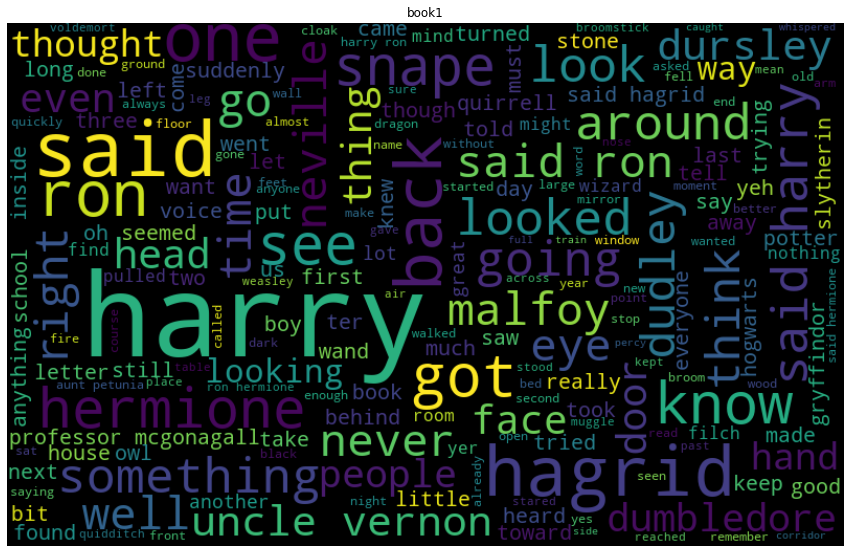

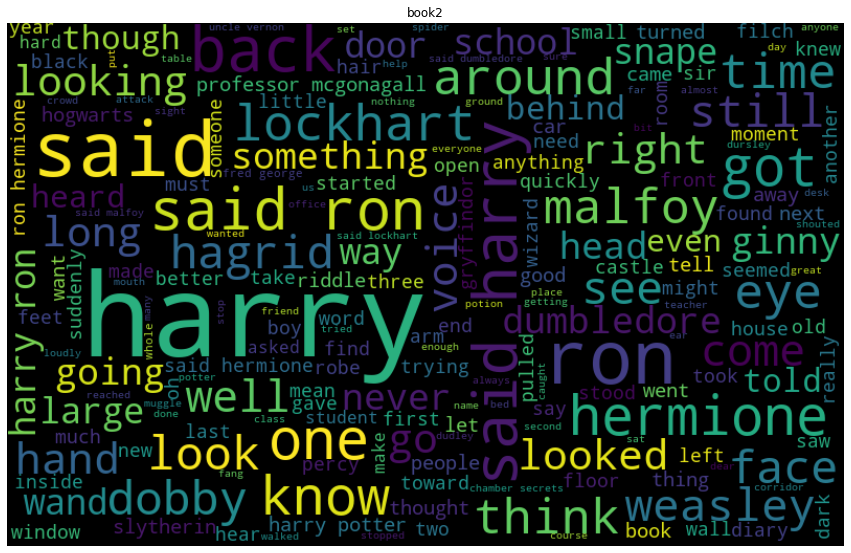

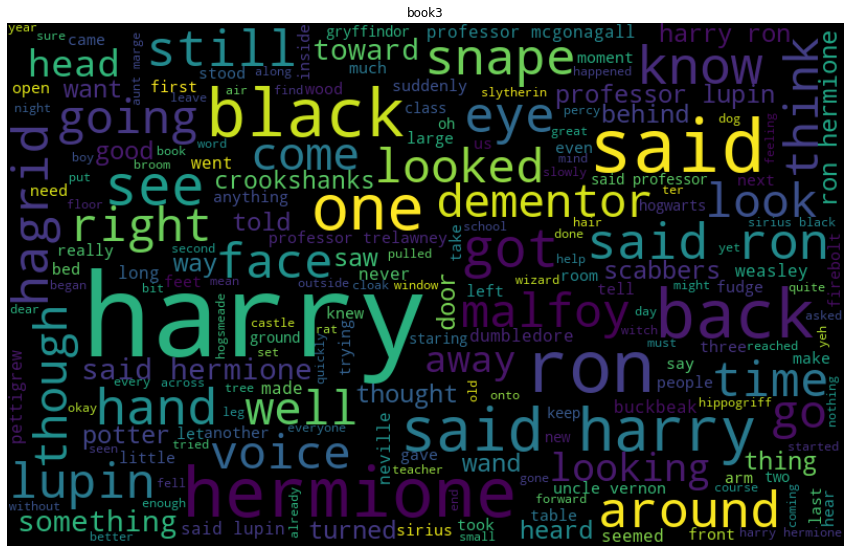

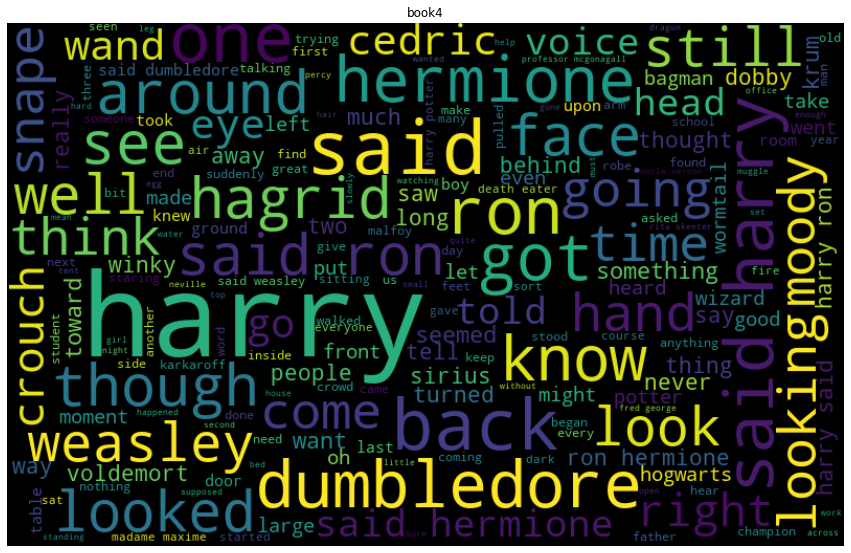

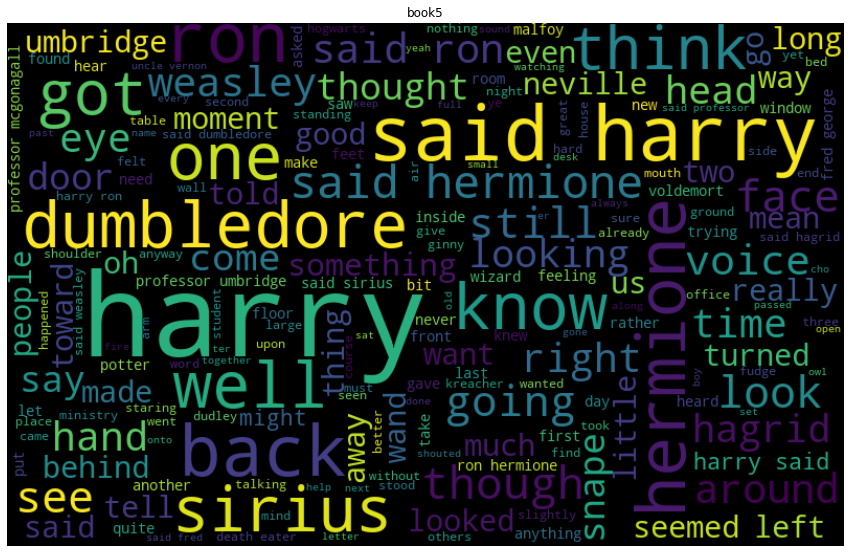

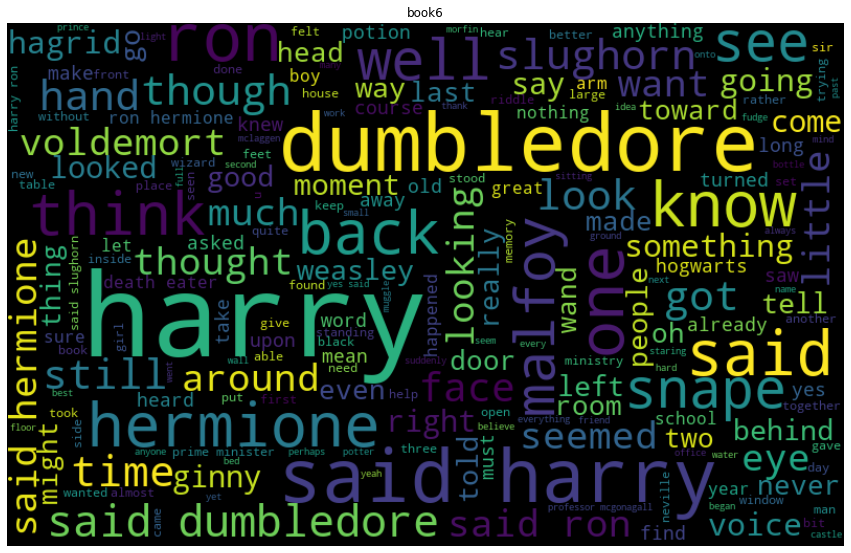

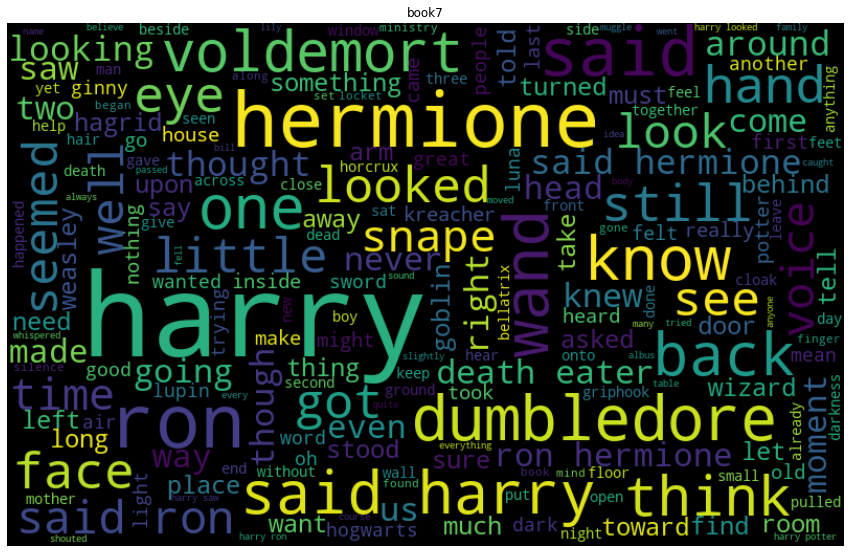

In [15]:
#Création des wordclouds

for i in all_text_clean:
    wordcloud = WordCloud(width=800, height=500,
                      random_state=21, max_font_size=110).generate(all_text_clean[i])
    plt.figure(figsize=(15, 12))
    plt.title(i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off');

In [16]:
#On crée une fonction qui détermine les mots qui reviennent le plus dans un texte ainsi que leur nombre d'apparition

def most_common_word(text_clean):
    text_clean_list = text_clean.split()
    text_counts = Counter(text_clean_list)
    text_common_words = [word[0] for word in text_counts.most_common(25)]
    text_common_counts = [word[1] for word in text_counts.most_common(25)]

    return text_common_words, text_common_counts

In [17]:
#Création d'un dictionnaire avec les mots les plus utilisés par tome

hp_most_common = {}
for i in all_text_clean:
    hp_most_common[i] = most_common_word(all_text_clean[i])

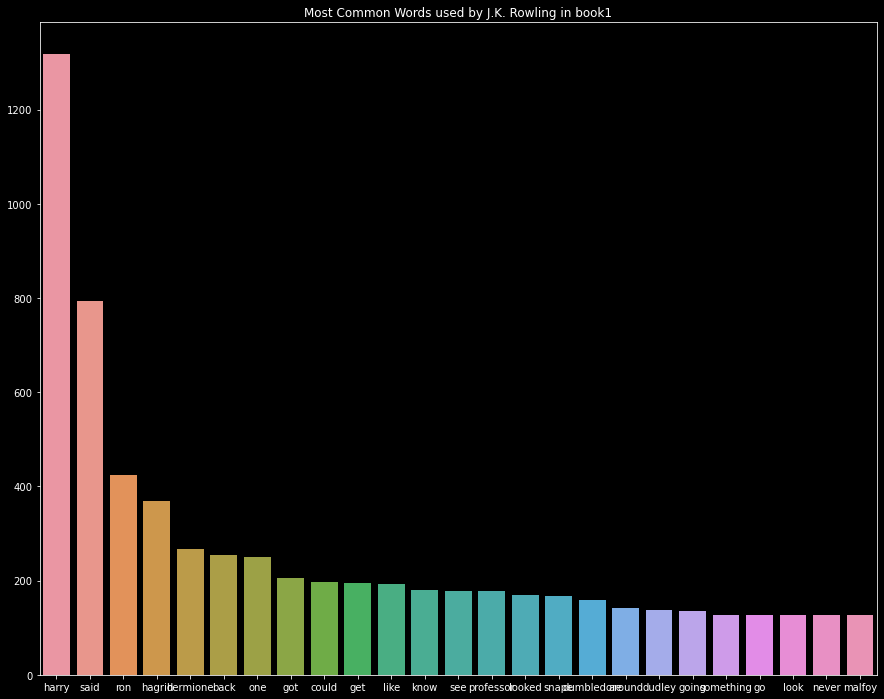

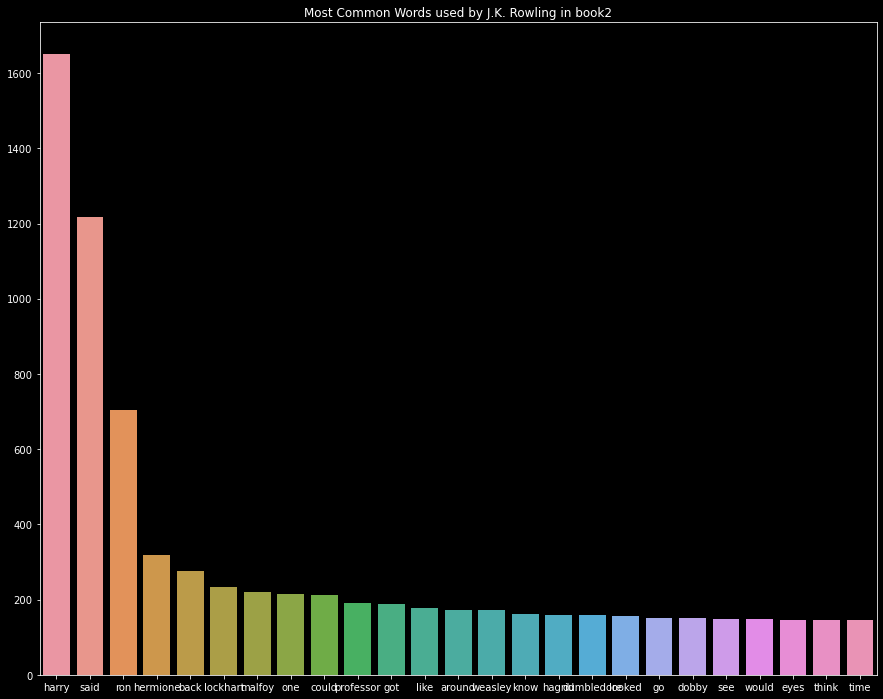

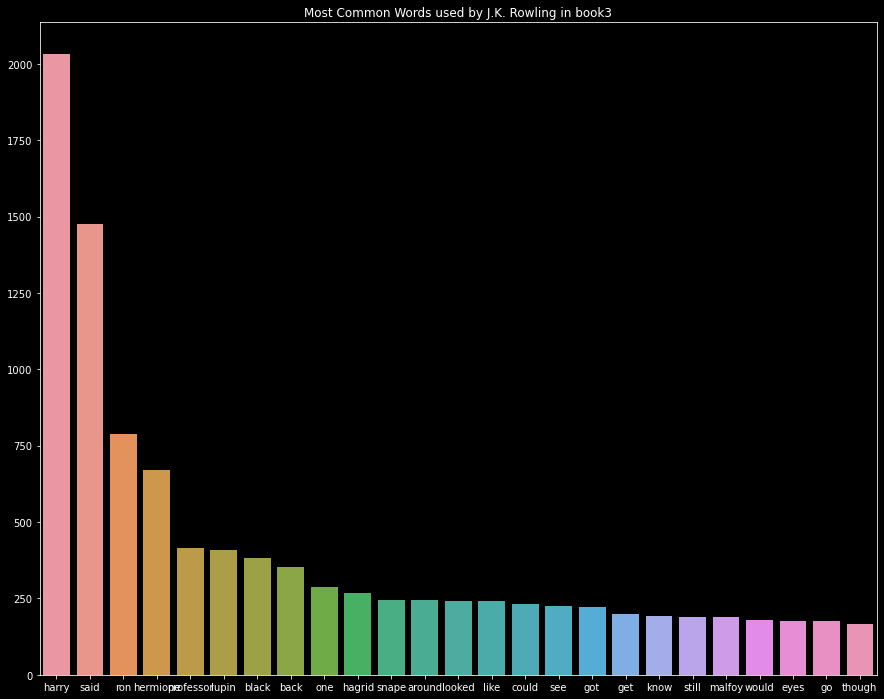

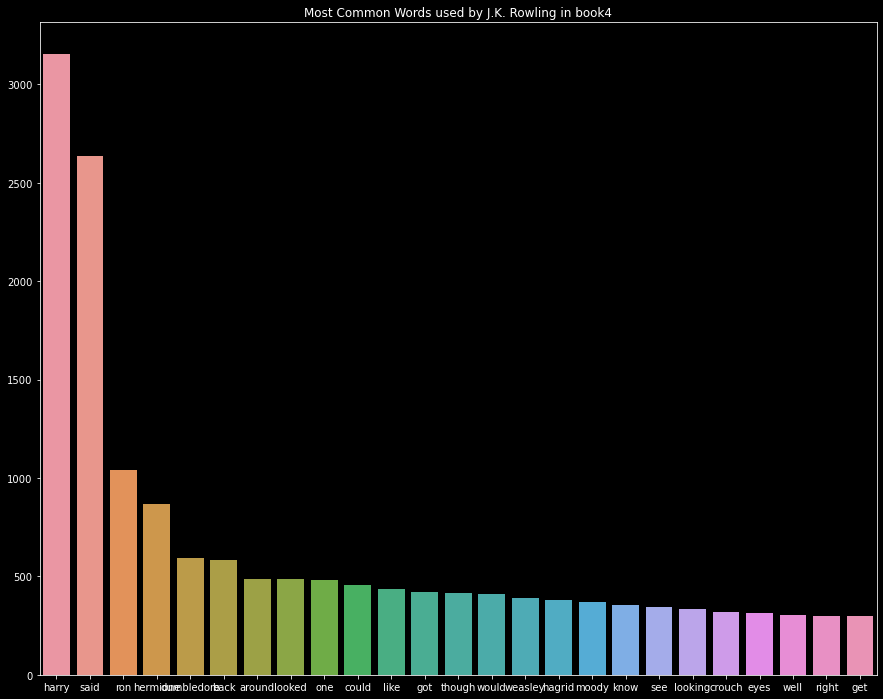

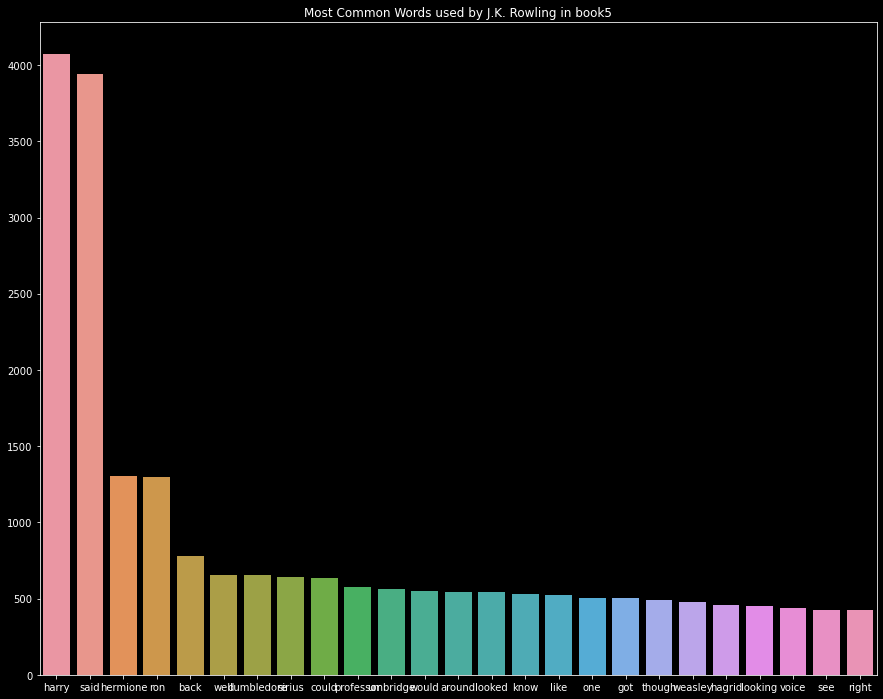

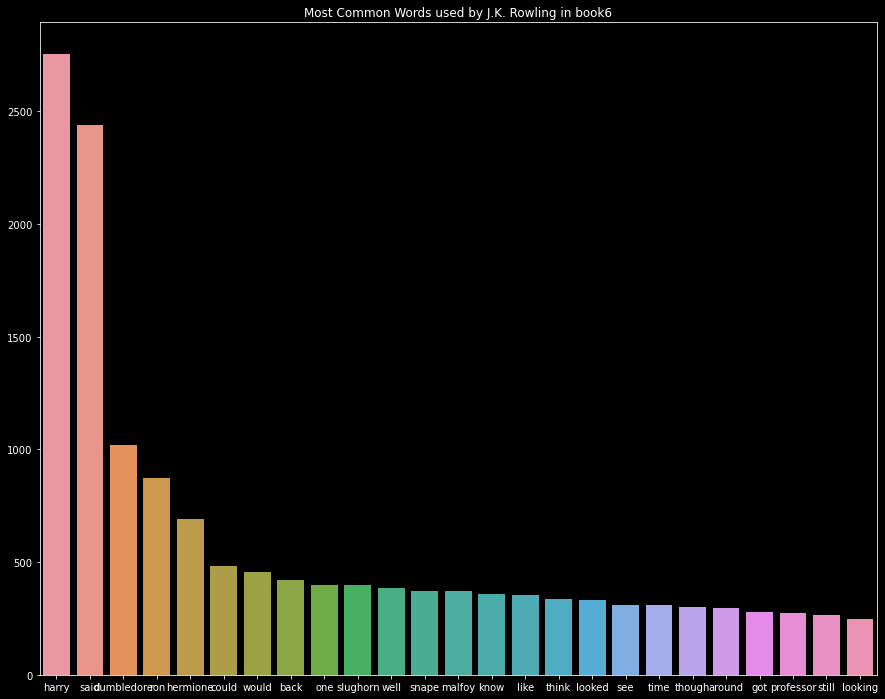

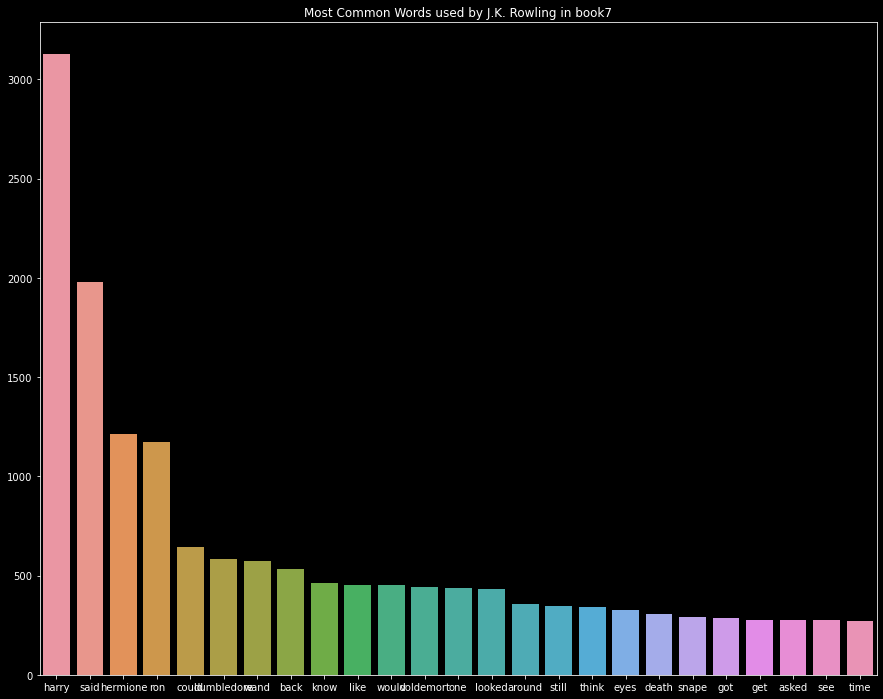

In [18]:
#On réalise les graphiques des mots les plus communs

for i in hp_most_common:
        plt.style.use('dark_background')
        plt.figure(figsize=(15, 12))
        words = hp_most_common[i][0]
        count = hp_most_common[i][1]
        sns.barplot(x = words, y = count)
        plt.title('Most Common Words used by J.K. Rowling in ' +i)

On constate que les mots qui reviennent le plus sont des noms de personnages (Harry, Ron, Hagrid) et des mots classiques du récit qui ne nous apportent pas beaucoup d'information (said, like, know, go).

On va maintenant travailler plus spécifiquement sur les personnages. On définit une fonction qui comptabilise les noms propres pour en sortir ceux qui reviennent le plus.

In [19]:
def noms_propres(text):
    
# On mettra dans la fonction all_text qui n'est pas totalement nettoyé car il contient encore les majuscules qui aident 
# à détecter les noms propres (all_text_clean n'a plus de majuscules)
    
    text = nltk.word_tokenize(text) # On tokenize simplement le texte pour l'avoir sous forme de mots séparés et plus de string
    text = nltk.pos_tag(text)
    
    nnp = []
    noms = []
    noms_final = []
    
    for i,element in enumerate(text):
        if element[1] == "NNP" and len(element[0]) > 2 :
            nnp.append(element[0]) # On met tous les noms propres rencontrés dans une liste
    
    for nom in nnp:
        count = nnp.count(str(nom))
        noms.append([str(nom),count]) # On compte dans la liste combien de fois reviennent les noms propres
   
    noms = sorted(noms,key = lambda item: item[1], reverse = True)

    for i in noms:
        if i not in noms_final:
            noms_final.append(i)

    noms_final = noms_final[:10] # On ne regarde que les 10 plus fréquents
    
    return (noms_final)

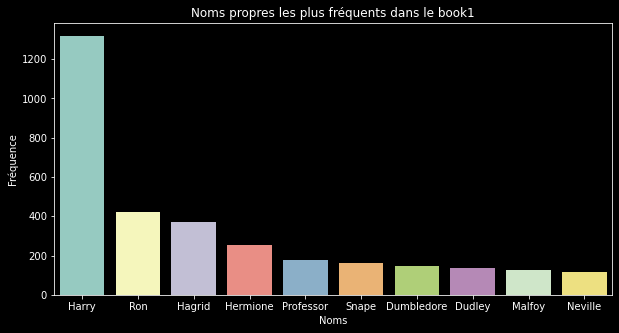

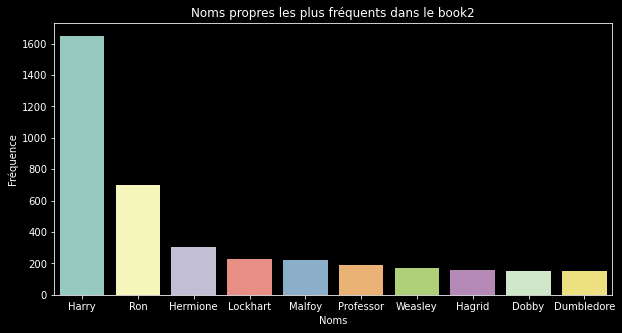

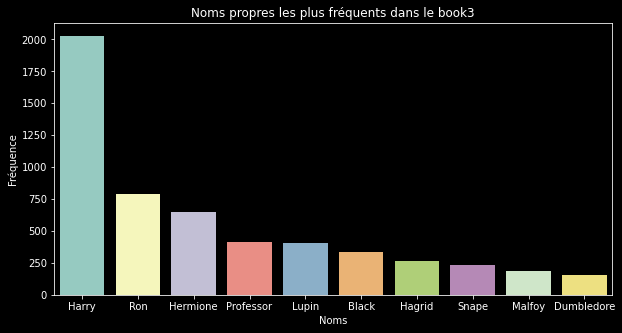

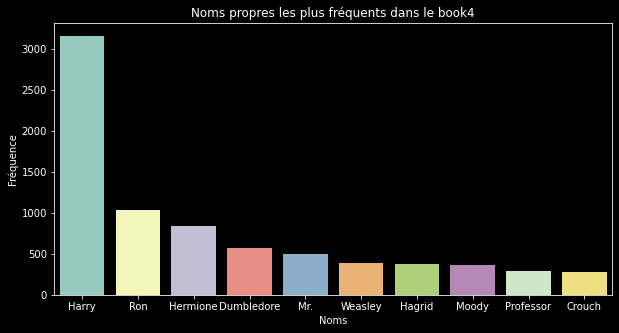

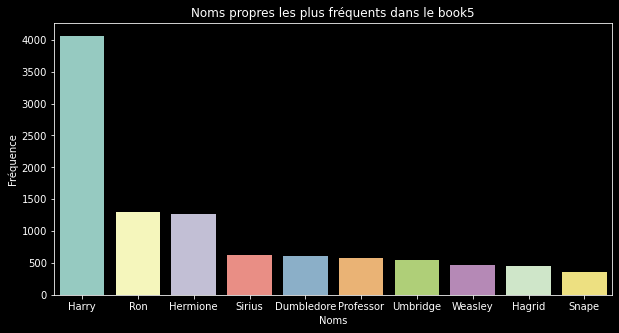

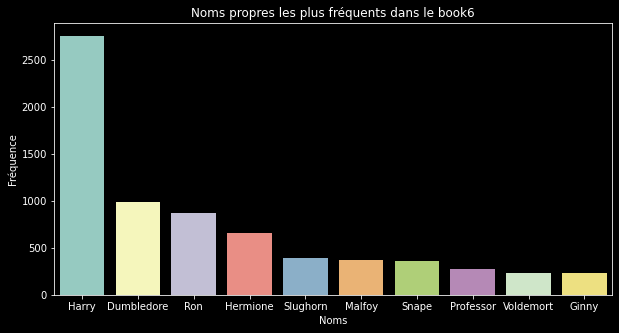

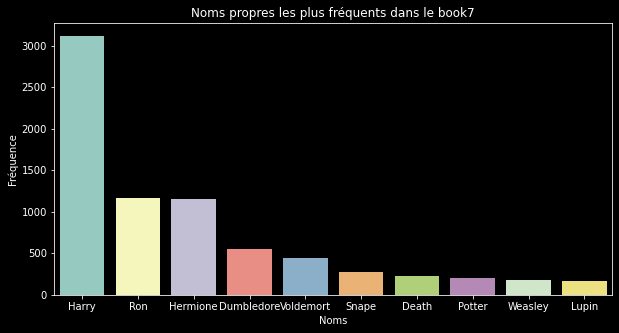

In [20]:
# On réalise des graphiques montrant les noms propres qui reviennent le plus dans chaque tome

noms_freq = []
for livre in all_text:
    plt.figure(figsize=(10, 5))
    df_freq_noms = pd.DataFrame(noms_propres(all_text[livre]), columns = ['Noms', 'Fréquence'])
    sns.barplot(x = df_freq_noms.Noms, y = df_freq_noms.Fréquence)
    plt.title('Noms propres les plus fréquents dans le ' +livre)

On constate sans surprise que les premiers noms sont toujours Harry, Ron et Hermione (excepté dans le tome 6 où Dumbledore prend la 3ème place).

##### Travail sur la relation entre les personnages 

Dans la suite on ne garde que les personnages qui reviennent le plus souvent au total.

In [21]:
# On regroupe les différentes formes sous lesquelles peuvent se retrouver les noms des personnages

harry = ['harry', 'harry potter']
ron = ['ron', 'ron weasley']
hermione = ['hermione granger','hermione']
ginny = ['ginny weasley', 'ginny']
dumbledore = ['albus dumbledore', 'dumbledore']
sirius = ['sirius black', 'sirius']
snape = ['severus snape', 'snape']
luna = ['luna lovegood', 'luna']
hagrid = ['rubeus hagrid', 'hagrid']
dobby = ['dobby']
draco = ['draco','malfoy']
voldemort = ['tom riddle', 'voldemort', 'you-know-who', 'know-who', 'lord']

personnages = [harry,ron,hermione,ginny,dumbledore,sirius,snape,luna,dobby,voldemort]

In [22]:
#Fonction récupérant l'index de chaque apparition d'un personnage

def occurence(text_list, perso):
    occurence_all = []
    
    for i in text_list:
        occurence = []
        
        for idx, word in enumerate(text_list[i]):
            if word in perso:
                occurence.append(idx)
        occurence_all.append(occurence)
        
    return occurence_all

In [23]:
# On transforme le texte propre en une liste de mots

all_text_clean_list = all_text_clean.copy()
for i in all_text_clean:
    all_text_clean_list[i] = all_text_clean[i].split()

In [24]:
# On applique la fonction à chaque personnage

harry_occ = occurence(all_text_clean_list, harry)
ron_occ = occurence(all_text_clean_list, ron)
hermione_occ = occurence(all_text_clean_list, hermione)
ginny_occ = occurence(all_text_clean_list, ginny)
dumbledore_occ = occurence(all_text_clean_list, dumbledore)
sirius_occ = occurence(all_text_clean_list, sirius)
snape_occ = occurence(all_text_clean_list, snape)
luna_occ = occurence(all_text_clean_list, luna)
hagrid_occ = occurence(all_text_clean_list, hagrid)
dobby_occ = occurence(all_text_clean_list, dobby)
draco_occ = occurence(all_text_clean_list, draco)
voldemort_occ = occurence(all_text_clean_list, voldemort)

###### On cherche à calculer un score de proximité entre les différents personnages et Harry Potter. 

In [50]:
def relation(perso_pdv, perso_cible):   #les arguments seront les listes d'occurence trouvées précédemment
    score_all = []
    
    for i in range(0,7): #on boucle sur tous les livres
        liens = 0   #compteur de liens
        list_index = []
        
        for idx in perso_pdv[i]:
            #on considère que deux personnages ont une interaction s'ils sont à moins de 40 mots d'écart
            idx_bas = idx - 40
            idx_haut = idx + 40
        
            for index in perso_cible[i]: 
                if (idx_bas <= index <= idx_haut):
                    liens += 1                     #si les index sont proches, on incrémente le compteur de liens
                    list_index.append([idx, index])
                    
        max_lien = float(len(perso_pdv[i])) #on calcule le nombre de liens potentiels ( = le nombre d'apparitions du personnage)
        liens_uniques = []
        
        for ele in list_index:
            if ele[0] not in liens_uniques:
                liens_uniques.append(ele[0]) 
        
        if max_lien != 0:
            score = ((len(liens_uniques) / max_lien)*100) #on fait le ratio entre le nombre de liens et le nombre de liens max
        else: score = 0
        
        score_all.append(score) #on stocke le score de chaque livre
        
    return score_all

In [51]:
# On applique la fonction au trio principal

harry2ron = relation(harry_occ, ron_occ)
ron2harry = relation(ron_occ, harry_occ) # On regarde les deux points de vue pour chaque relation
harry2hermione = relation(harry_occ, hermione_occ)
hermione2harry = relation(hermione_occ, harry_occ)
ron2hermione = relation(ron_occ, hermione_occ)
hermione2ron = relation(hermione_occ, ron_occ)

In [52]:
# On l'applique aussi aux autres personnages 

harry2sirius = relation(harry_occ, sirius_occ)
harry2dumbledore = relation(harry_occ, dumbledore_occ)
harry2snape = relation(harry_occ, snape_occ)
harry2voldemort = relation(harry_occ, voldemort_occ)
harry2ginny = relation(harry_occ, ginny_occ)
harry2hagrid = relation(harry_occ, hagrid_occ)
harry2draco = relation(harry_occ,draco_occ)
sirius2harry = relation(sirius_occ, harry_occ)
dumbledore2harry = relation(dumbledore_occ, harry_occ)
snape2harry = relation(snape_occ, harry_occ)
voldemort2harry = relation(voldemort_occ, harry_occ)
ginny2harry = relation(ginny_occ, harry_occ)
hagrid2harry = relation(hagrid_occ, harry_occ)
draco2harry = relation(draco_occ,harry_occ)

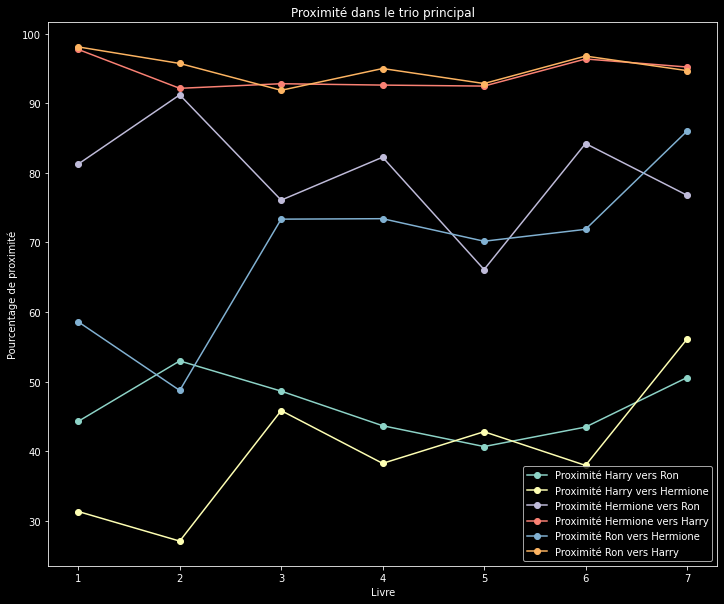

In [28]:
# On représente ces relations sous forme de graphiques

x = np.linspace(1,7,7)
plt.figure(figsize=(12,10))
plt.plot(x, harry2ron, marker = 'o', label = 'Proximité Harry vers Ron')
plt.plot(x, harry2hermione, marker = 'o', label = 'Proximité Harry vers Hermione')
plt.plot(x, hermione2ron, marker = 'o', label = 'Proximité Hermione vers Ron')
plt.plot(x, hermione2harry, marker = 'o', label = 'Proximité Hermione vers Harry')
plt.plot(x, ron2hermione, marker = 'o', label = 'Proximité Ron vers Hermione')
plt.plot(x, ron2harry, marker = 'o', label = 'Proximité Ron vers Harry')
plt.legend(loc = 'best', prop = {'size': 10})
plt.title('Proximité dans le trio principal')
plt.xlabel('Livre')
plt.ylabel('Pourcentage de proximité')
plt.show()

On remarque que les proximités les plus élevées sont celles de Ron et Hermione vers Harry, ce qui semble logique: quand ces personnages apparaissent, ils sont souvent à proximité du personnage principal là où Harry a plus de chances d'apparaitre dans des contextes différents (seul par exemple), du fait de la focalisation interne du récit.

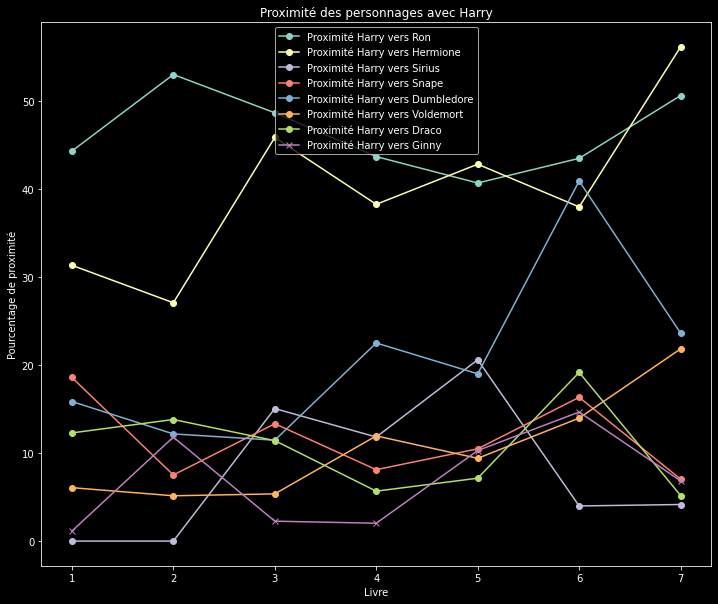

In [29]:
# On regarde le graphique des autres relations du point de vue d'Harry
x = np.linspace(1,7,7)
plt.figure(figsize=(12,10))
plt.plot(x, harry2ron, marker = 'o', label = 'Proximité Harry vers Ron')
plt.plot(x, harry2hermione, marker = 'o', label = 'Proximité Harry vers Hermione')
plt.plot(x, harry2sirius, marker = 'o', label = 'Proximité Harry vers Sirius')
plt.plot(x, harry2snape, marker = 'o', label = 'Proximité Harry vers Snape')
plt.plot(x, harry2dumbledore, marker = 'o', label = 'Proximité Harry vers Dumbledore')
plt.plot(x, harry2voldemort, marker = 'o', label = 'Proximité Harry vers Voldemort')
plt.plot(x, harry2draco, marker = 'o', label = 'Proximité Harry vers Draco')
plt.plot(x, harry2ginny, marker = 'x', label = 'Proximité Harry vers Ginny')
plt.legend(loc = 'best', prop = {'size': 10})
plt.title('Proximité des personnages avec Harry')
plt.xlabel('Livre')
plt.ylabel('Pourcentage de proximité')
plt.show()

On retrouve les résultats du graphique précédent montrant les noms propres les plus fréquents: Ron et Hermione ont les plus forts pourcentages de proximité avec Harry, sauf dans le 6 où Dumbledore dépasse Hermione. Cela démontre que l'apparition des personnages au cours des livres sont totalement conditionnée par leur relation avec le personnage principal.

### Modélisation des données 

On cherche à présent à caractériser ces interactions car elles n'ont pas la même nature selon les personnages ou selon les tomes. Pour cela, nous allons avoir recours à l'analyse de sentiments.

In [57]:
# On a 20 relations: 9 avec Harry-autre perso, 2 Ron-Hermione et inversement, et 9 autre perso-Harry
# On crée un dictionnaire avec pour chaque livre les personnages de départ, les personnages d'arrivée et le poids de leur relation associée

perso_depart = [harry[1]]*9 + [ron[1], hermione[1], ron[1], hermione[1], ginny[1], draco[1], voldemort[1], sirius[1], snape[1], dumbledore[1], hagrid[1]]
persos_arrivee = [ron[1], hermione[1], ginny[1], draco[1], voldemort[1], sirius[1], snape[1], dumbledore[1], hagrid[1], hermione[1], ron[1]] + [harry[1]]*9

data_persos = {}

for i in range(7):
    data_persos['book' + str(i+1)] = {'perso depart': perso_depart, 'persos arrivee': persos_arrivee,
            'poids': [harry2ron[i], harry2hermione[i], harry2ginny[i], harry2draco[i], harry2voldemort[i], harry2sirius[i], harry2snape[i], harry2dumbledore[i], harry2hagrid[i],
            ron2hermione[i], hermione2ron[i], ron2harry[i], hermione2harry[i], ginny2harry[i], draco2harry[i], voldemort2harry[i], sirius2harry[i], snape2harry[i], dumbledore2harry[i], hagrid2harry[i]]
                                    }

In [59]:
df1 = pd.DataFrame(data_persos['book1'], columns = {'persos arrivee', 'poids', 'perso depart'})
df2 = pd.DataFrame(data_persos['book2'], columns = {'persos arrivee', 'poids', 'perso depart'})
df3 = pd.DataFrame(data_persos['book3'], columns = {'persos arrivee', 'poids', 'perso depart'})
df4 = pd.DataFrame(data_persos['book4'], columns = {'persos arrivee', 'poids', 'perso depart'})
df5 = pd.DataFrame(data_persos['book5'], columns = {'persos arrivee', 'poids', 'perso depart'})
df6 = pd.DataFrame(data_persos['book6'], columns = {'persos arrivee', 'poids', 'perso depart'})
df7 = pd.DataFrame(data_persos['book7'], columns = {'persos arrivee', 'poids', 'perso depart'})

In [60]:
# On crée une liste des occurences pour chauqe personnage. Chaque élément de occ_list est la liste des occurences d'un tome

occ_list = []
for i in range(7):
    occ_list.append([len(harry_occ[i]), len(ron_occ[i]), len(hermione_occ[i]), len(ginny_occ[i]), len(draco_occ[i]),
             len(voldemort_occ[i]), len(sirius_occ[i]), len(snape_occ[i]), len(dumbledore_occ[i]), len(hagrid_occ[i])])

In [ ]:
# On définit la somme des éléments d'une liste et la moyenne d'une liste

def somme(liste):
    _somme = 0
    for i in liste:
        _somme = _somme + i
    return _somme

def moyenne(liste):
    return somme(liste)/len(liste)